In [1]:
import fsspec
import xarray as xr
import numpy as np

#file_path = "/Users/adamhunter/Downloads/VIIRS_Rasterized_2021-07-31_7_bool.nc"
#file_path="/Users/adamhunter/Downloads/VIIRS_Rasterized_2021-07-31_8_bool.nc"
file_path = "/Users/adamhunter/Downloads/VIIRS_Rasterized_2021-08-11_8_bool.nc"
with fsspec.open(file_path) as f:
    ds = xr.open_dataset(f)
    arr = ds.to_array()

ds

<xarray.Dataset>
Dimensions:      (x: 89, y: 54)
Coordinates:
  * x            (x) float64 -106.7 -106.7 -106.7 ... -106.2 -106.2 -106.2
  * y            (y) float64 45.78 45.78 45.77 45.77 ... 45.5 45.5 45.49 45.49
Data variables:
    spatial_ref  int64 0
    bool         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [2]:
arr = ds['bool']

Count of 0's:  <xarray.DataArray 'bool' ()>
array(4806)
Count of 1's:  <xarray.DataArray 'bool' ()>
array(152)


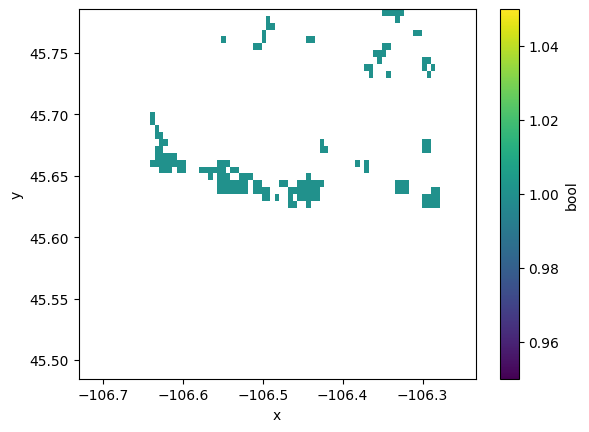

In [3]:



# Print descriptive statistics about the array
print("Count of 0's: ", (arr != 0).sum())
print("Count of 1's: ", (arr == 1).sum())

# Plotting the array
arr.plot()



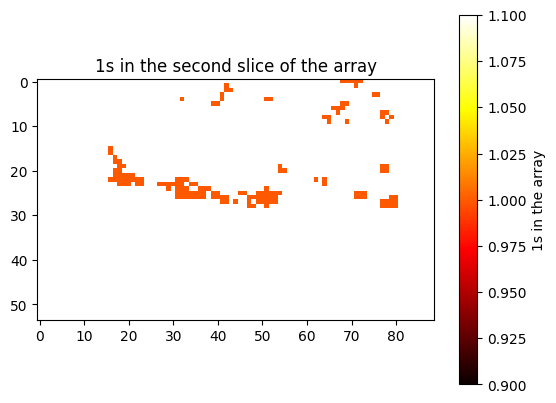

In [4]:
import matplotlib.pyplot as plt

plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.colorbar(label='1s in the array')
plt.title('1s in the second slice of the array')
plt.show()

In [5]:
from scipy.ndimage import binary_dilation, binary_erosion, label
from skimage.morphology import convex_hull_image
from shapely.geometry import Polygon, mapping, Point
import geopandas as gpd
import json
import numpy as np
from skimage.measure import find_contours

# Replace NaN values with 0s
arr.data = np.nan_to_num(arr.data)

# Dilation and Erosion
dilated = binary_dilation(arr.data)
eroded = binary_erosion(dilated)

# Connected Components Labelling
labeled_array, num_features = label(eroded)
# Initialize an empty list to store the polygons
polygons = []

# Loop over each feature
for i in range(1, num_features + 1):
    # Get the feature
    feature = labeled_array == i
    
    # Find the contours of the feature
    contours = find_contours(feature, 0.5)
    
    # Loop over each contour
    for contour in contours:
        # Use the contour coordinates to get the corresponding latitudes and longitudes
        feature_lats = ds.y.values[contour[:, 0].astype(int)]
        feature_lons = ds.x.values[contour[:, 1].astype(int)]
        
        # Convert the latitudes and longitudes to a polygon and add it to the list
        polygons.append(Polygon(zip(feature_lons, feature_lats)))

# Convert the list of polygons to a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons)

# Convert the GeoDataFrame to GeoJSON
geojson = gdf.to_json()

print(geojson)

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-106.50418793588305, 45.75514899942591], [-106.50976373069747, 45.75514899942591], [-106.51533952551189, 45.75514899942591], [-106.50976373069747, 45.76072479424033], [-106.50976373069747, 45.76072479424033], [-106.50418793588305, 45.766300589054744], [-106.50418793588305, 45.766300589054744], [-106.49861214106865, 45.771876383869156], [-106.49861214106865, 45.771876383869156], [-106.49861214106865, 45.777452178683575], [-106.49303634625423, 45.78302797349799], [-106.49303634625423, 45.777452178683575], [-106.48746055143981, 45.777452178683575], [-106.48746055143981, 45.771876383869156], [-106.48746055143981, 45.771876383869156], [-106.49303634625423, 45.766300589054744], [-106.49303634625423, 45.766300589054744], [-106.49861214106865, 45.76072479424033], [-106.49861214106865, 45.76072479424033], [-106.50418793588305, 45.75514899942591], [-106.50

In [6]:
# Import folium for map visualization
import folium

# Create a map centered around the data
m = folium.Map(location=[45.7836, -106.3450], zoom_start=9)

# Add the GeoJSON data to the map
folium.GeoJson(geojson).add_to(m)

# Display the map
m


In [7]:
from scipy.ndimage import binary_dilation, binary_erosion, label
from skimage.measure import find_contours
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import xarray as xr

def open_dataset(file_path):
    with fsspec.open(file_path) as f:
        ds = xr.open_dataset(f)
    return ds

def preprocess_data(ds):
    arr = ds.to_array()
    arr.data = np.nan_to_num(arr.data)
    return arr

def perform_dilation_erosion(arr):
    dilated = binary_dilation(arr.data)
    eroded = binary_erosion(dilated)
    return eroded

def label_features(eroded):
    labeled_array, num_features = label(eroded)
    return labeled_array, num_features

def create_polygons(labeled_array, num_features, ds):
    polygons = []
    for i in range(1, num_features + 1):
        feature = labeled_array == i
        contours = find_contours(feature, 0.5)
        for contour in contours:
            feature_lats = ds.y.values[contour[:, 0].astype(int)]
            feature_lons = ds.x.values[contour[:, 1].astype(int)]
            polygons.append(Polygon(zip(feature_lons, feature_lats)))
    return polygons

def convert_to_geojson(polygons):
    gdf = gpd.GeoDataFrame(geometry=polygons)
    geojson = gdf.to_json()
    return geojson

def process_file(file_path):
    ds = open_dataset(file_path)
    arr = preprocess_data(ds)
    eroded = perform_dilation_erosion(arr)
    labeled_array, num_features = label_features(eroded)
    polygons = create_polygons(labeled_array, num_features, ds)
    geojson = convert_to_geojson(polygons)
    return geojson